In [5]:
import pandas as pd
import scipy.io as scio
import itertools
import numpy as np
import os
import matplotlib.pyplot as plt
import argparse
import seaborn as sns

In [6]:
def lag_data_generate(HS_list, clean_data_path):
    place_list = []
    avgECoG = {}
    sound_list1 = ["ba", "bu", "da", "du", "ga", "gu"]
    task_name_list1 = ["overt", "covert"]
    sound_list2 = ["ba", "da", "ga", "pa", "ta", "ka", "sa", "sha"]
    task_name_list2 = ["overt", "covert", "cue"]
    for task in task_name_list2:
        avgECoG[task] = {}

    for HS in HS_list:
        xycolor = scio.loadmat(clean_data_path + "\\HSblockdata\\elecs\\warped\\HS" + str(HS) + "_elecs_all_warped.mat")["anatomy"]
        elec_sig = np.load(clean_data_path + "\\HSblockdata\\elecs\\elec_sig\\" + str(HS) + "sig_elecs.npy", allow_pickle=True).item()
        place_list.extend(np.unique(xycolor[:, 3]))

        for task in task_name_list2:
            for i in range(len(place_list)):
                if place_list[i][0] not in avgECoG[task].keys():
                    avgECoG[task][place_list[i][0]] = []

        clean_data_path_block = os.path.join(clean_data_path, "HSblockdata")
        file_name = "HS" + str(HS) + "_Block_overt_covert.mat"
        HSblock = scio.loadmat(os.path.join(clean_data_path_block, file_name))
        HSblock = HSblock["Alldata"][0][0]
        n_chans = xycolor.shape[0]
        # 为各个place各个task增加一行对特定音节该电极上的平均
        for i in range(n_chans):
            if HS >54:
                for task in task_name_list2:
                    if i in elec_sig[task]:
                        for sound in sound_list2:
                            avgECoG[task][xycolor[i, 3][0]].append(np.mean(HSblock["ECoG_"+task+"_"+sound][:, i, :], axis=0))
            else:
                for task in task_name_list1:
                    if i in elec_sig[task]:
                        for sound in sound_list1:
                            avgECoG[task][xycolor[i, 3][0]].append(np.mean(HSblock["ECoG_"+task+"_"+sound][:, i, :], axis=0))
    place_list = np.unique(place_list)
    return place_list, avgECoG

In [7]:

def lag_plot(HS_list, clean_data_path):
    n_windows = 5
    # 选择是否高斯平滑：如果高斯平滑n为多少
    place_list, avgECoG = lag_data_generate(HS_list, clean_data_path)
    gauss = True
    sound_list2 = ["ba", "da", "ga", "pa", "ta", "ka", "sa", "sha"]
    task_name_list2 = ["overt", "covert", "cue"]
    for task in task_name_list2:
        for i in range(len(place_list)):
            avgECoG[task][place_list[i]] = np.array(avgECoG[task][place_list[i]])
            if avgECoG[task][place_list[i]].shape[0] == 1:
                avgECoG[task][place_list[i]] = np.expand_dims(avgECoG[task][place_list[i]],0)
            if gauss:
                for j in range(avgECoG[task][place_list[i]].shape[0]):
                    avgECoG[task][place_list[i]][j] = np.convolve(avgECoG[task][place_list[i]][j], np.ones([n_windows]) / n_windows, mode="same")

    blank_list = []
    forward = int(40)
    backward = int(150)
    #新建字典 存储task
    task_dict={}
    
    for task in task_name_list2:
        vtask_dict={}
        onset = {}
        onset_t={}
        peak = {}
        peak_t={}
        offset = {}
        offset_t={}
        for i in range(len(place_list)):
            temp = avgECoG[task][place_list[i]]
            if len(temp) == 0:
                blank_list.append(i)
                continue
            # temp[temp<0]=0
            onset[place_list[i]] = np.argmax(np.diff(temp, axis=1)[:, -forward+150:backward+150], axis=1)
            num = 100
            onset_t[place_list[i]] = (np.argmax(np.diff(temp, axis=1)[:, -forward + 150:backward + 150], axis=1)-forward)/num
            offset[place_list[i]] = np.zeros_like(onset[place_list[i]])
            offset_t[place_list[i]] = np.zeros_like(onset[place_list[i]]).astype(np.float64)
            peak[place_list[i]] = np.zeros_like(onset[place_list[i]])
            peak_t[place_list[i]] = np.zeros_like(onset[place_list[i]]).astype(np.float64)
            for j in range(len(onset[place_list[i]])):
                offset[place_list[i]][j] = np.argmin(np.diff(temp, axis=1)[[j], -forward + 150:backward+150], axis=1)
                peak[place_list[i]][j] = np.argmax(temp[[j], -forward + 150:backward+150], axis=1)
                offset_t[place_list[i]][j] = (np.argmin(np.diff(temp, axis=1)[[j], -forward + 150:backward+150], axis=1)-forward)/num
                peak_t[place_list[i]][j] = (np.argmax(temp[[j],-forward + 150:backward + 150], axis=1)-forward)/num
        task_dict[task]={'onset':onset_t,'peak':peak_t,'offset':offset_t}
        for key in task_dict[task].keys():
            temp1=task_dict[task][key]
            y_tick=temp1.keys()
            fig,ax=plt.subplots(figsize=(10,10))
            values=[value for value in temp1.values()]
            print(values)
            sns.boxplot(data=values,orient='horizontal',width=0.3,flierprops={'markersize': 1})
            ax.set_title(f'{task}'+'_'+f'{key}')
            ax.set_yticklabels(y_tick,fontsize=8)
            ax.set_xlabel('Latency(s)')
            plt.show()

# latency的箱型图

[array([ 1.08, -0.37,  0.62,  0.98, -0.04,  0.74,  1.02, -0.31,  1.14,
        0.38,  0.58,  1.39,  0.47,  0.46,  1.35,  0.75,  0.26,  1.32,
        0.95, -0.38,  0.33,  0.47,  0.75,  0.78,  0.24,  0.42,  0.96,
        1.49,  0.33,  0.59,  0.73,  0.8 ,  0.21,  1.35,  0.93,  1.08,
        0.28,  0.54,  1.48,  0.96,  1.01,  0.34, -0.14,  0.44,  0.31,
        0.45,  0.83,  0.7 ]), array([ 0.45,  0.12,  1.29,  0.19, -0.18,  0.87,  0.52,  0.06,  0.26,
       -0.19,  0.52,  0.65,  1.49,  0.07,  0.25, -0.19,  0.54,  0.01,
        0.48,  1.32,  0.28, -0.14,  0.88, -0.06,  1.36,  1.36,  0.45,
        0.6 ,  0.85,  0.71,  0.05,  0.13, -0.13, -0.3 ,  0.09,  0.58,
       -0.06,  0.17, -0.13, -0.02,  0.09,  0.6 ,  0.04,  0.22, -0.13,
       -0.04,  0.04,  0.6 ,  0.52,  0.53,  0.42,  0.34,  0.34,  0.33,
        0.52,  0.56,  0.68,  0.53,  0.32,  0.62,  1.39,  0.58,  0.66,
        0.79,  0.59,  0.59,  1.39,  0.12, -0.1 , -0.33,  0.12,  0.59,
       -0.07,  0.1 , -0.12,  1.38,  0.11,  0.56,  1.2 ,  0.

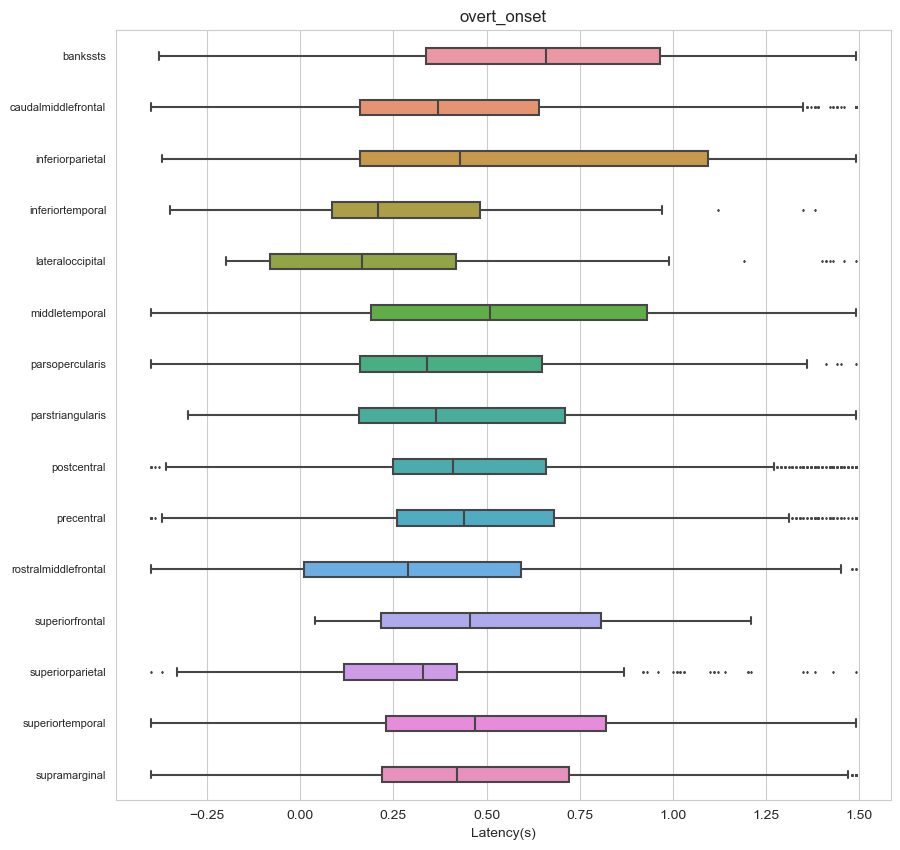

[array([ 1.25, -0.25,  0.78,  1.07,  0.79,  0.46, -0.38,  1.05,  1.49,
        0.51,  0.7 ,  0.84,  0.74,  0.9 ,  1.47,  1.05,  1.18,  0.57,
        1.04, -0.29,  0.83,  0.79,  0.87,  1.01,  1.14,  0.58,  1.05,
       -0.28,  0.49,  0.72,  0.87,  0.98,  0.26,  1.46,  1.09,  1.17,
        0.84,  0.96,  0.86,  1.04,  1.11,  0.96,  1.14,  0.55,  1.1 ,
        1.48,  0.93,  0.91]), array([ 0.69,  1.42,  0.81,  0.91,  0.61,  0.95,  0.65,  1.47,  0.4 ,
        1.01,  0.64,  0.98,  0.56,  0.81,  0.37,  1.01,  0.65,  0.95,
        0.67,  1.42,  0.37,  0.41,  0.59,  0.02,  0.98,  1.1 ,  0.52,
        0.76,  1.02,  0.82,  0.21,  0.3 ,  0.57,  0.32,  0.2 ,  0.81,
        0.24,  0.32,  0.59,  0.31,  0.22,  0.73,  0.18,  0.34,  1.49,
        1.49,  0.23,  0.83,  0.71,  0.73,  0.82,  0.84,  0.8 ,  0.83,
        0.74,  0.73,  0.81,  0.88,  0.82,  0.8 ,  1.02,  0.72,  0.79,
        0.89,  1.03,  0.78,  1.49,  0.74,  0.67,  0.9 ,  1.11,  0.77,
        0.16,  0.32,  0.07,  1.47,  0.25,  0.78,  0.25,  0.

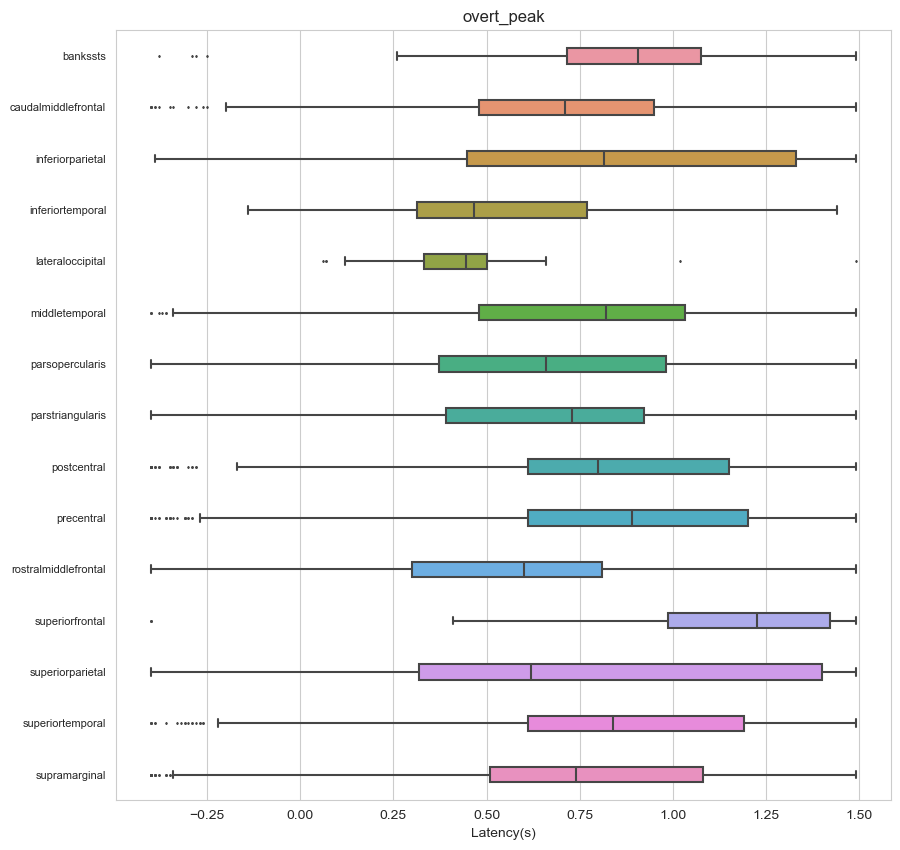

[array([ 0.83, -0.16,  0.04, -0.2 ,  0.9 ,  0.55, -0.29,  0.19, -0.17,
        0.7 ,  1.09, -0.18,  0.81,  0.08,  0.02,  1.15,  0.4 ,  0.63,
        1.24, -0.19,  1.1 ,  1.04,  1.06,  0.34,  1.49,  1.06,  1.11,
       -0.19, -0.23,  1.03,  0.99,  1.27, -0.4 ,  1.18,  1.18,  0.03,
        0.02,  0.39,  0.94,  1.29, -0.4 ,  1.25, -0.33,  0.63,  0.14,
        0.09, -0.32, -0.06]), array([ 0.81,  0.45,  0.98,  1.08,  1.01,  1.21,  0.78, -0.23,  0.92,
        1.1 ,  0.78,  1.09,  0.65, -0.22,  0.81, -0.4 ,  0.74,  1.05,
        0.83,  0.79,  0.47,  1.16,  0.7 ,  0.09,  1.17,  1.19,  1.03,
        0.97, -0.3 ,  0.9 ,  0.48,  1.01,  0.17, -0.4 ,  1.31,  1.25,
        0.54,  0.77,  0.78, -0.4 ,  0.36, -0.4 ,  0.6 ,  0.44,  0.85,
        0.43,  0.35, -0.4 , -0.22,  1.14, -0.21,  1.03,  1.08,  0.96,
        1.24, -0.23, -0.21,  1.02,  1.11,  0.92, -0.19, -0.24,  0.93,
        0.99,  1.24,  1.27, -0.2 ,  0.81,  0.18,  0.97,  1.31,  1.25,
        0.89,  0.46,  0.76,  0.37,  0.36, -0.4 ,  0.53,  0.

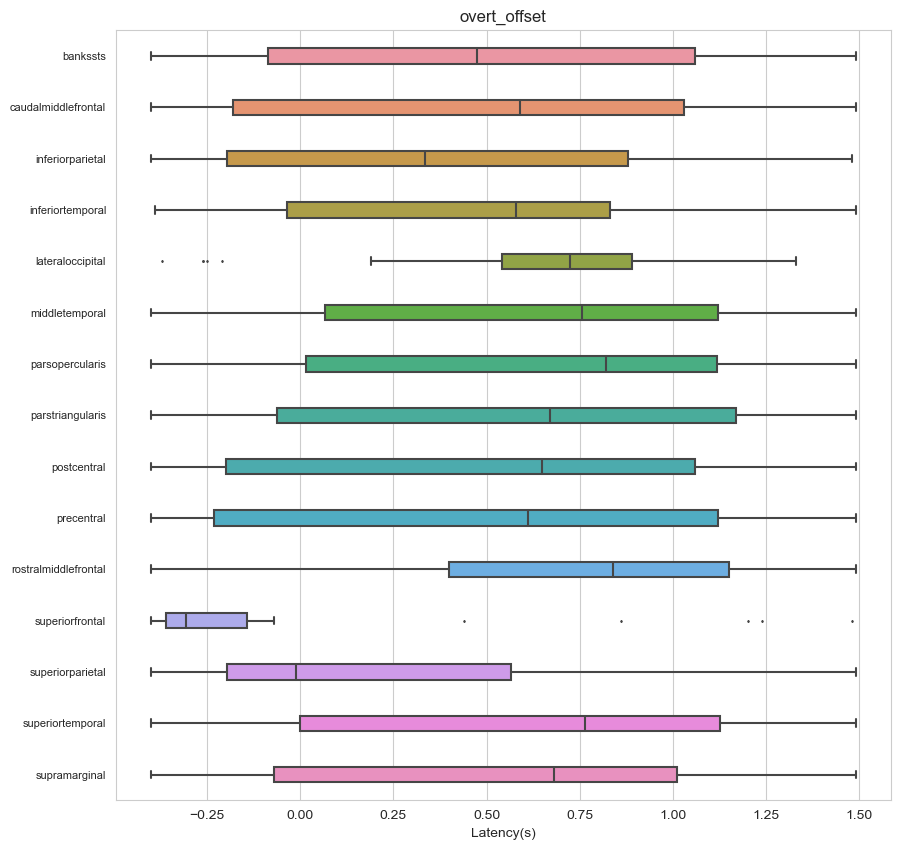

[array([ 0.39,  1.28, -0.18,  0.75,  0.48,  0.57,  0.44,  0.33,  0.33,
       -0.21,  0.57,  0.27, -0.37,  0.48, -0.17,  0.48,  0.83, -0.22,
       -0.23,  1.23,  0.7 ,  0.69,  0.06,  0.42]), array([ 1.48, -0.18,  0.32,  0.41,  1.04,  0.74,  0.42,  1.13,  0.26,
        0.43,  0.38,  1.43,  0.36,  0.09, -0.12, -0.4 ,  0.32,  1.48,
        0.97,  0.44,  0.02, -0.18,  0.31,  0.57,  0.53,  1.15,  0.3 ,
        0.36,  0.13,  1.49,  1.33,  1.47,  0.29,  0.45,  0.4 ,  0.53,
        1.  ,  0.53, -0.24,  0.53,  0.29,  0.28,  1.41,  0.01,  0.9 ,
        0.09,  0.73,  0.56,  0.  ,  1.44,  1.45,  0.06, -0.13,  0.2 ,
       -0.01,  0.09, -0.07,  0.09,  0.21,  0.19,  0.07,  0.07, -0.08,
        0.14,  0.12, -0.02,  0.4 ,  0.53,  0.65,  0.71,  0.51,  0.72,
        0.74,  0.44,  1.49,  0.77,  0.5 ,  0.71,  0.4 , -0.01,  1.49,
        0.77,  1.25,  0.66, -0.03,  0.15,  1.46,  0.77, -0.11,  0.58,
        0.01,  1.39, -0.08,  0.07,  1.2 ,  0.19,  0.01,  0.03, -0.06,
       -0.03,  0.01, -0.03,  0.31,  0.

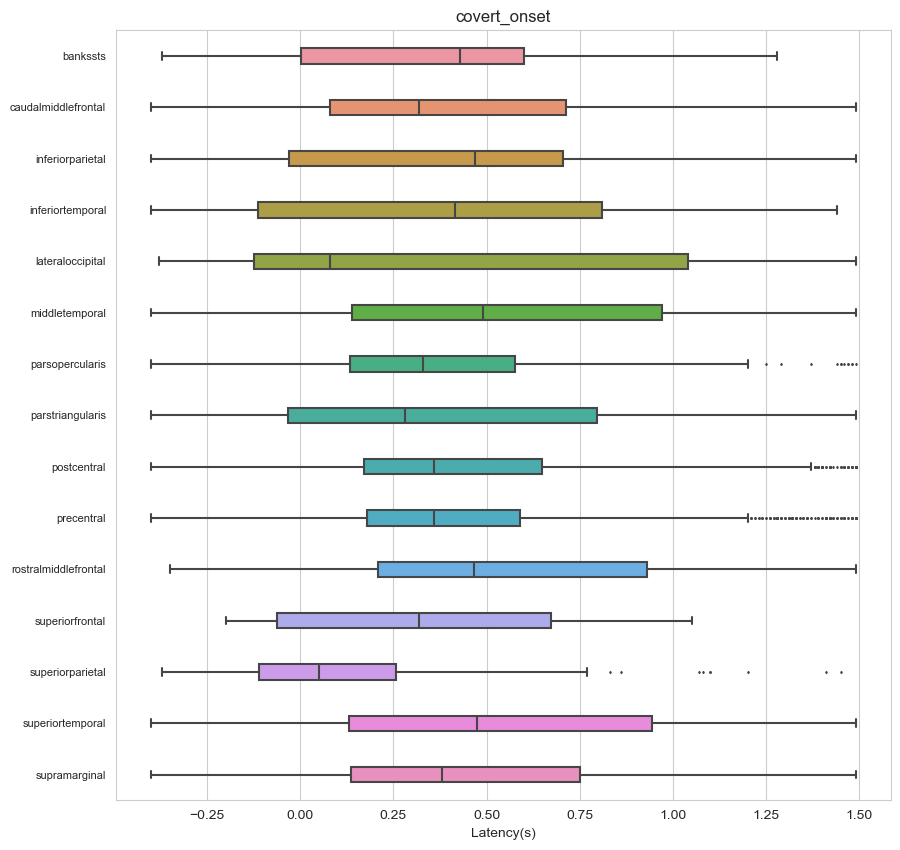

[array([ 0.49,  1.44,  1.14,  0.83, -0.16,  0.71,  0.57,  0.76, -0.27,
        0.42,  1.18, -0.35, -0.28, -0.33,  0.69,  1.01,  1.16, -0.08,
        1.45,  1.34,  0.79,  0.79,  0.93,  0.71]), array([ 0.5 ,  0.85,  0.44, -0.12,  1.18,  0.85,  0.51, -0.27,  0.55,
        0.52,  0.47,  0.76,  0.56,  0.2 ,  0.47,  0.62,  0.44,  1.49,
        1.13,  0.6 ,  0.11,  0.47,  0.54, -0.36,  0.62,  0.13,  0.42,
        0.47,  0.26,  0.35,  0.5 ,  0.42,  0.54,  1.15,  0.52,  0.69,
        0.16,  0.65,  0.4 ,  1.22,  0.76, -0.33,  1.49,  0.3 ,  0.97,
       -0.4 ,  1.33,  0.91,  0.23,  0.5 ,  1.05,  0.86,  0.84,  0.29,
        0.26,  0.29,  0.26,  0.24,  0.3 ,  0.3 ,  0.26,  0.27,  0.94,
        0.26,  0.26,  0.31,  0.88,  0.7 ,  1.11,  0.87,  0.96,  0.89,
        0.86,  0.73,  1.13,  0.87,  0.94,  0.88,  0.81,  1.  ,  1.26,
       -0.4 ,  1.32,  0.88,  0.78,  1.04,  1.49,  1.11,  1.31,  0.87,
        0.2 ,  0.23,  1.49,  0.25,  0.26,  0.29,  0.23,  0.23,  0.18,
        0.21,  0.26,  0.26,  0.85,  0.

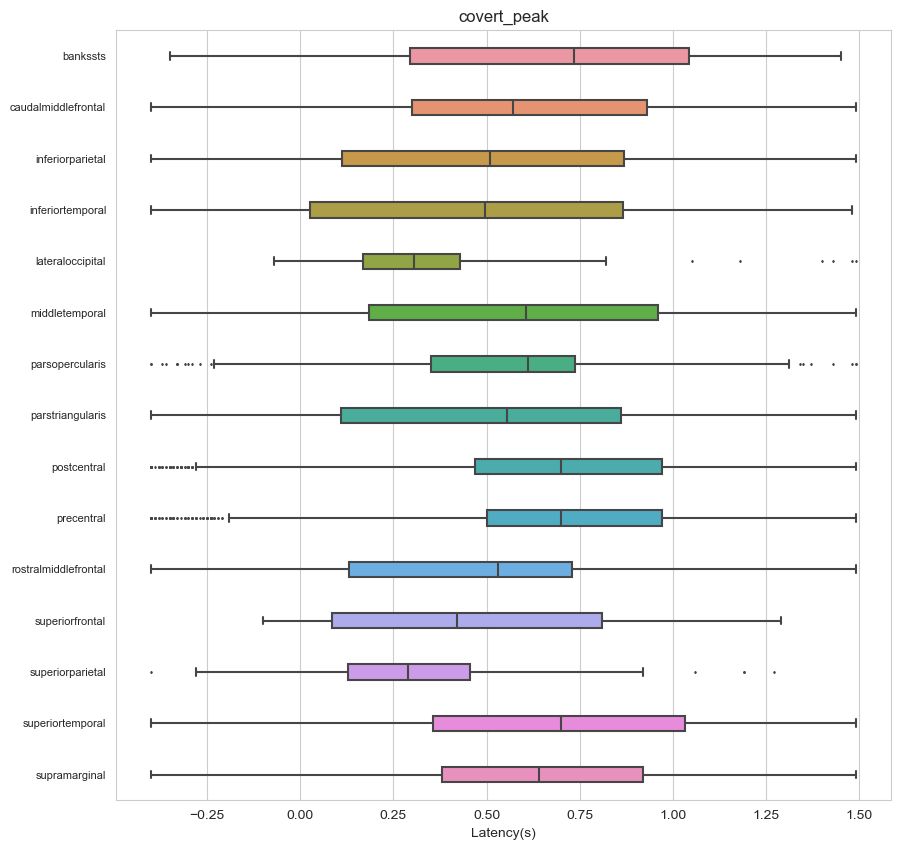

[array([ 1.13, -0.15, -0.38,  0.91,  0.19,  0.79,  1.26,  0.83, -0.16,
        1.47,  1.44, -0.23, -0.2 ,  0.04, -0.01,  1.37,  1.27,  0.02,
       -0.05,  1.44,  1.23,  0.91,  1.06, -0.03]), array([ 0.64,  0.93,  0.56,  0.26,  1.31, -0.03,  0.79,  0.98,  0.87,
        1.16,  1.24,  0.9 ,  0.82,  0.94,  0.61,  0.72,  0.5 ,  0.94,
        1.21, -0.28,  0.93,  0.06,  0.1 ,  0.39,  0.74,  0.26,  0.53,
        0.58,  0.44,  0.45,  0.57,  0.91, -0.29,  1.26, -0.24,  0.81,
        0.74,  0.79,  0.61,  1.31,  0.85, -0.22, -0.4 ,  0.38, -0.32,
       -0.32,  0.3 , -0.4 , -0.27,  0.57, -0.31, -0.36,  1.37,  0.38,
        0.45,  0.59, -0.39,  0.33,  0.37,  0.4 , -0.4 ,  0.44, -0.4 ,
        0.36,  0.39,  0.43, -0.33,  1.49, -0.31, -0.15, -0.17,  0.97,
       -0.37,  1.3 ,  0.01, -0.11, -0.2 , -0.37, -0.29, -0.27,  0.02,
       -0.35,  1.37, -0.36, -0.28,  1.17, -0.31,  1.21,  1.37, -0.38,
       -0.26,  0.57,  0.29, -0.36,  0.4 ,  0.4 ,  0.49,  0.38,  0.29,
        0.29,  0.41,  0.4 , -0.33,  0.

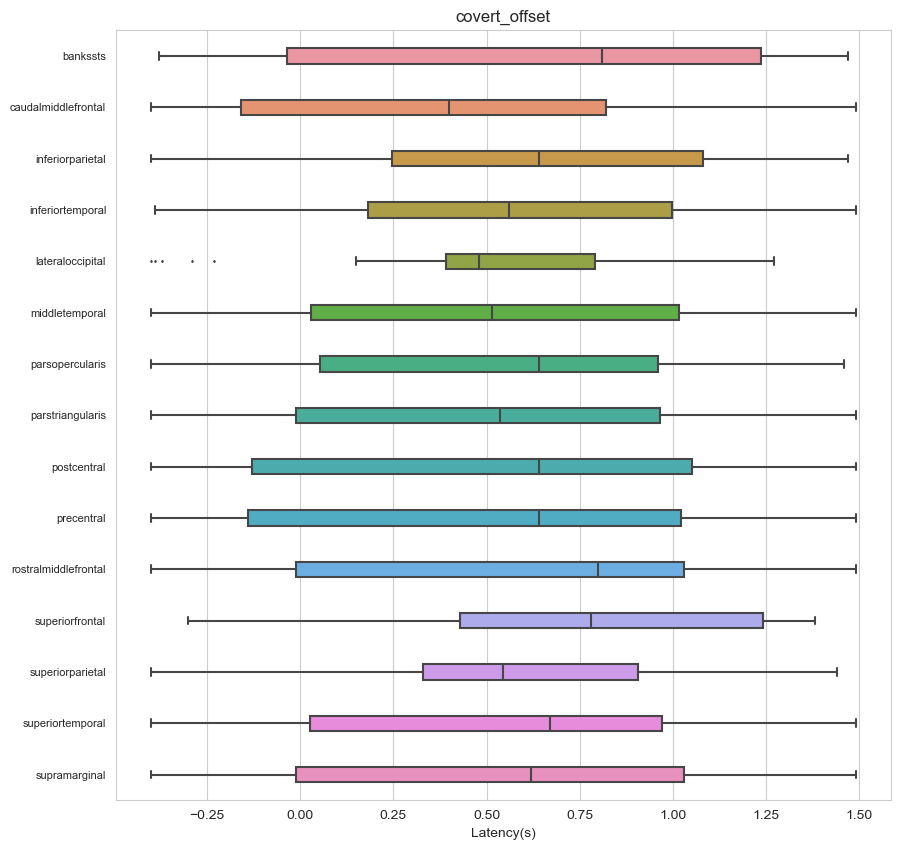

[array([ 0.69,  0.34,  0.46, -0.29,  0.6 ,  0.4 ,  0.37,  0.24,  0.65,
        0.63,  0.53,  0.73,  0.39,  0.4 ,  1.29,  0.94,  0.68,  0.36,
        0.51,  1.12,  0.4 ,  0.42,  0.41,  0.29,  0.41, -0.09,  0.56,
       -0.35,  0.4 ,  0.44,  0.87,  0.65,  0.53, -0.09,  0.54,  0.47,
        0.51,  0.45,  0.85,  0.67, -0.01,  0.61, -0.09,  0.37,  0.42,
        0.56,  0.34, -0.09]), array([ 0.16,  1.41,  0.41, -0.12,  0.67,  0.85,  0.77,  1.33,  0.16,
        1.45,  0.9 ,  0.39,  0.64,  0.6 ,  0.76, -0.21,  1.27,  0.55,
        0.94, -0.07,  0.65,  0.58,  1.17,  0.78,  1.13,  0.15,  0.48,
        1.02,  0.22,  0.8 ,  0.77, -0.19,  0.27,  0.67,  0.1 ,  1.05,
        0.22,  0.77,  0.68,  0.76,  0.24,  0.83,  0.08,  0.98,  0.76,
        0.73,  0.71,  0.77,  0.55,  0.63,  0.51,  0.44,  0.58,  0.4 ,
        0.69,  0.71,  0.62,  0.54,  0.47,  0.34,  0.59,  0.34,  0.67,
        0.69,  1.07, -0.16,  0.19,  1.28,  0.74, -0.08,  0.46,  1.21,
        0.4 , -0.06, -0.15,  0.64,  0.48,  0.56, -0.33,  0.

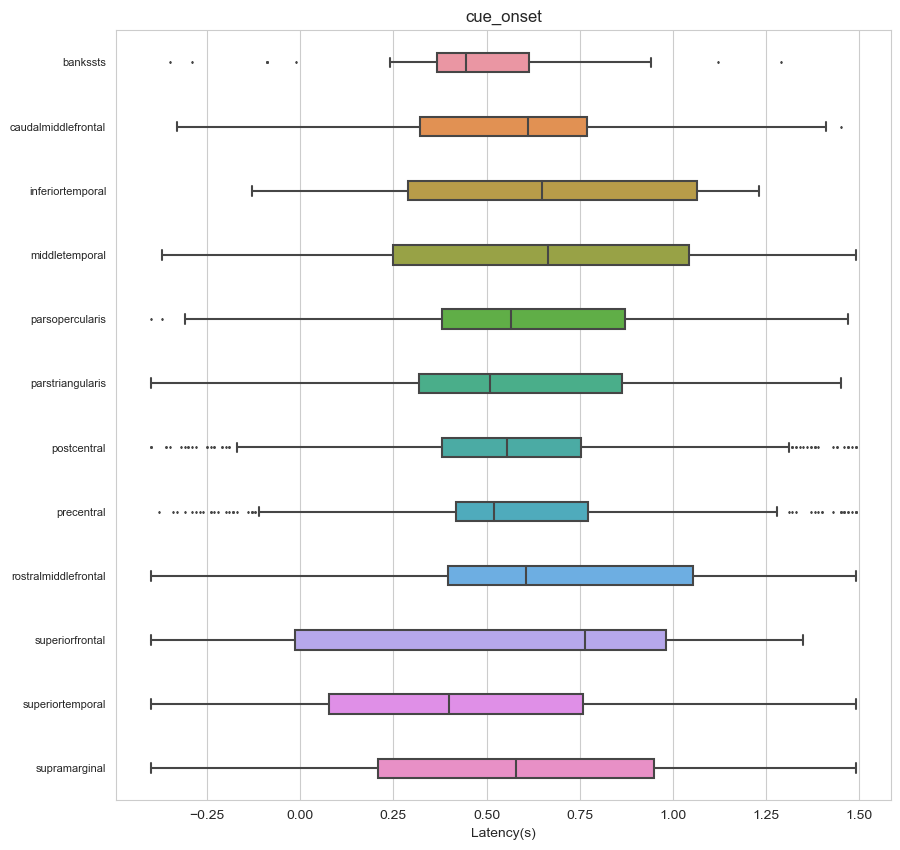

[array([ 0.77,  0.84,  0.67,  1.4 ,  1.17,  0.54,  0.54,  1.49,  0.83,
        0.08,  0.68,  0.81,  1.21,  0.75, -0.34,  0.28,  0.8 ,  0.82,
        0.66,  1.23,  1.18,  0.55,  1.14,  1.47,  0.81,  0.85,  0.68,
        1.23,  0.87,  0.68, -0.36,  1.4 ,  0.82,  0.86,  0.67,  1.21,
        0.85,  0.73, -0.36,  1.01,  0.91,  1.05,  0.66,  0.49,  0.52,
        0.67, -0.36,  0.02]), array([-0.23, -0.31,  1.33,  1.12, -0.4 ,  0.95,  0.87, -0.07,  0.27,
       -0.37, -0.4 ,  0.04, -0.4 ,  0.87,  0.92,  1.04, -0.2 , -0.3 ,
        1.29,  0.41, -0.4 ,  0.86, -0.1 ,  1.02,  0.3 , -0.21,  1.22,
       -0.37, -0.4 ,  1.  , -0.29, -0.11,  0.34, -0.29,  1.33,  0.25,
       -0.4 ,  0.88, -0.13, -0.25,  0.37, -0.35,  1.32,  1.35, -0.4 ,
        0.85, -0.4 , -0.14,  1.09,  0.78,  0.96,  0.94,  0.87,  0.05,
        1.  ,  1.3 ,  1.12,  1.49,  0.97,  0.93,  0.98, -0.37,  1.4 ,
        1.31,  1.49, -0.02,  0.31,  0.83,  1.43,  0.87, -0.31, -0.34,
       -0.1 ,  0.02,  0.93,  0.72,  0.05,  0.65,  0.31,  1.

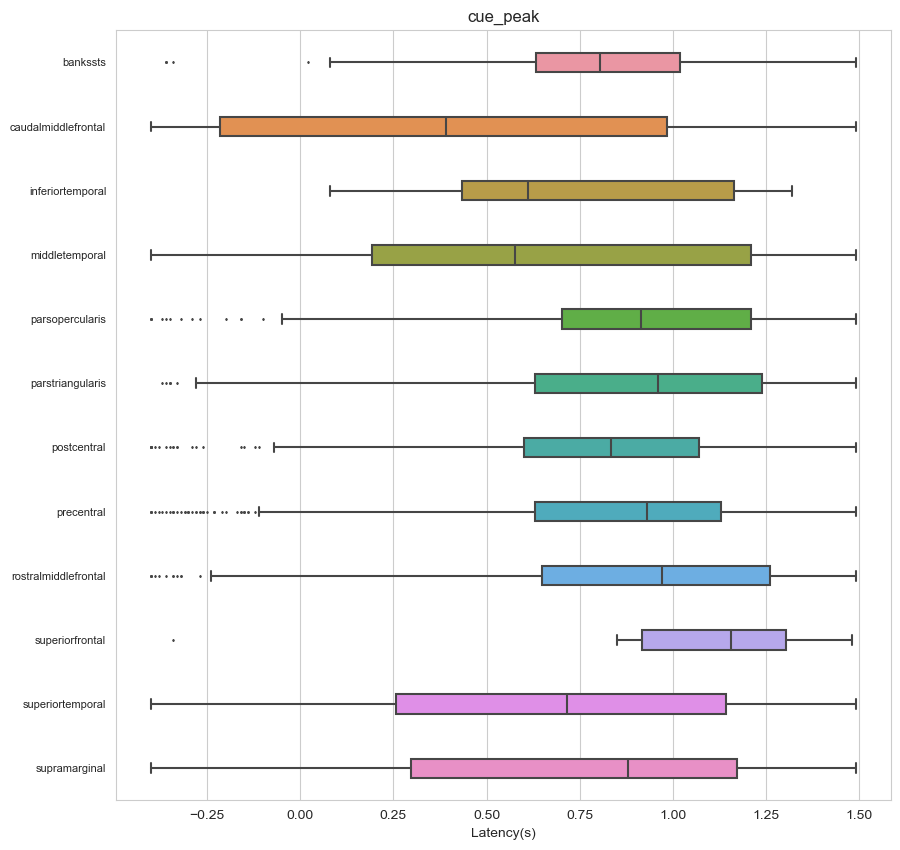

[array([ 0.24,  0.17,  0.15,  0.9 ,  1.38,  0.12, -0.21,  0.05,  0.25,
        0.26,  0.84,  0.88,  0.22,  0.1 , -0.21,  0.49,  0.23,  0.15,
        0.23,  1.49,  1.38,  0.14, -0.21,  0.1 ,  0.2 , -0.29,  0.25,
        0.21,  0.17, -0.24,  0.2 ,  0.06,  0.91, -0.31,  1.12,  0.08,
        0.17, -0.24,  0.22,  0.06,  0.19,  0.23,  0.21,  1.22, -0.28,
        0.77, -0.2 ,  0.08]), array([-0.14, -0.12, -0.13,  0.19, -0.32,  1.02,  0.05,  1.16,  0.38,
       -0.27,  1.04,  0.11, -0.36,  1.49,  0.43,  1.15, -0.1 ,  0.24,
        0.11,  0.5 , -0.33,  0.94, -0.01,  1.15,  0.41, -0.06,  1.45,
        0.6 ,  0.41,  0.47, -0.18,  1.13,  0.45, -0.16,  0.35,  1.49,
       -0.39,  1.49,  0.37,  1.09,  0.45,  0.48,  0.38,  1.43, -0.34,
        1.18,  0.48,  1.11,  0.25,  0.28,  0.28,  0.19,  0.19,  0.19,
        1.09,  0.18,  1.25,  0.29,  0.3 ,  0.17,  0.18,  0.21,  1.49,
        0.28, -0.28,  0.34,  1.32,  0.96, -0.34,  1.49, -0.2 , -0.26,
        0.26, -0.22,  1.03, -0.31,  0.3 ,  0.87,  0.41, -0.

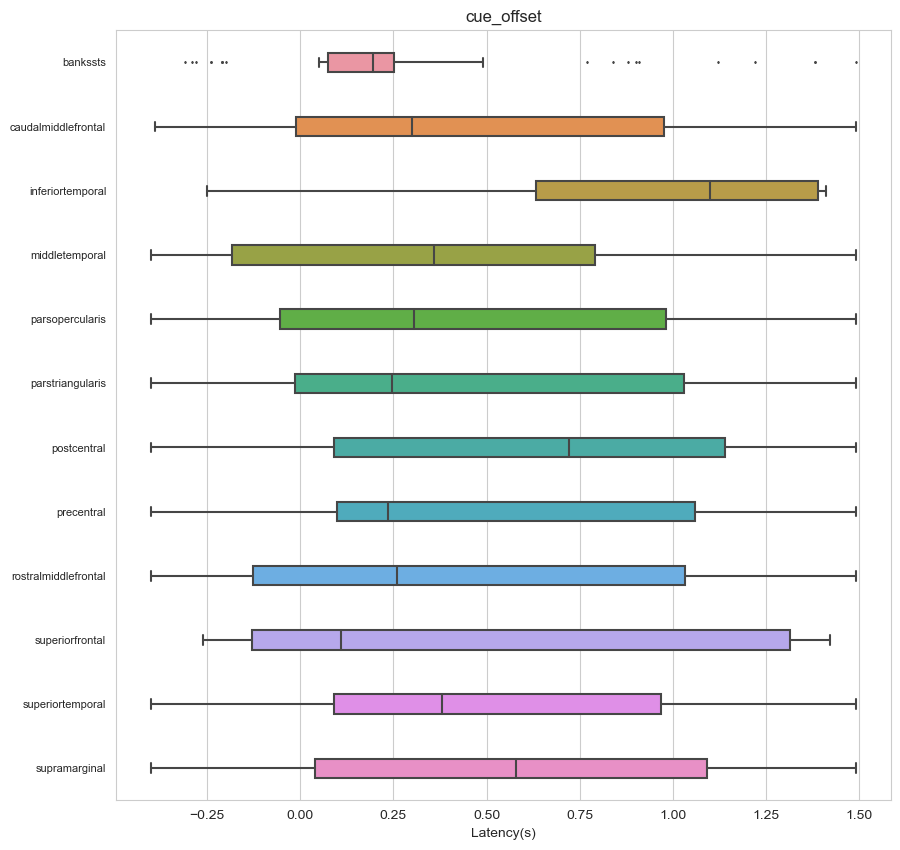

In [8]:
    HS_list = [44, 45, 47, 48, 50, 54, 71, 73, 76,78]
    clean_path_data="E:\\vs\\python\\data_for_code"
    lag_plot(HS_list, clean_path_data)